In [1]:
from datetime import datetime
import dask.array as da
import os
import time
import h5py
import numpy as np
import xarray as xr
import downscale as down
import matplotlib.pyplot as plt

import warnings

import cartopy
import cartopy.feature as cf
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec

import warnings
warnings.filterwarnings('ignore')

In [2]:
resolution = '3h'

In [36]:
tmpa_dir = os.path.join('..', 'data', 'tmpa_conus_data')
inputfile = os.path.join(tmpa_dir, f'data_tmpa_{resolution}_cut_upscale.nc')
output_file = os.path.join('..', 'data', 'down_test')

In [4]:
print(f'Read data to {inputfile}')
# ncf = xr.open_dataset(inputfile, engine="h5netcdf",phony_dims='sort') # FOR HDF5
ncf = xr.open_dataset(inputfile)

tmpalat = ncf['lat'][:].values
tmpalon = ncf['lon'][:].values
dates = ncf['time'][:].values
dset = ncf['PRE'].values

print(f'Precipitation data shape: {dset.shape}')

dset = np.swapaxes(dset,0,2)

del ncf

Read data to ../data/tmpa_conus_data/data_tmpa_3h_cut_upscale.nc
Precipitation data shape: (2433, 6, 8)


In [5]:
clat = 34.875
clon = -98.125

dx = 0.5
dy = 0.5

clat = tmpalat[0]
clon = tmpalon[0] + 4*dx

In [6]:
npix = 3
buffer = 0.50*npix*dx
eps = 1e-4 # to make sure to include boundaires -> add an eps buffer

x = da.from_array(dset, chunks=(6, 6, 300))
xrs0 = xr.DataArray(x,  coords={'lon':tmpalon, 'lat':tmpalat, 'time':dates}, dims=('lon', 'lat', 'time'))

# set negative values to NaN (missing values)
xrs = xrs0.where(xrs0 >= -0.001)
nlon = xrs.shape[0]
nlat = xrs.shape[1]
ntime = xrs.shape[2]

solat = clat - buffer + eps
nolat = clat + buffer + eps
ealon = clon + buffer + eps
welon = clon - buffer + eps
bcond = np.logical_and(
            np.logical_and( xrs.lat > solat, xrs.lat < nolat),
            np.logical_and( xrs.lon > welon, xrs.lon < ealon))

# XARRAY WITH VALUES LOADED IN MEMORY
box_3h = xrs.where(bcond, drop = True).load()
print(box_3h.shape)

(3, 2, 2433)


In [7]:
lon2d, lat2d = np.meshgrid(xrs0['lon'], xrs0['lat'])
lon2d_box, lat2d_box = np.meshgrid(box_3h['lon'], box_3h['lat'])

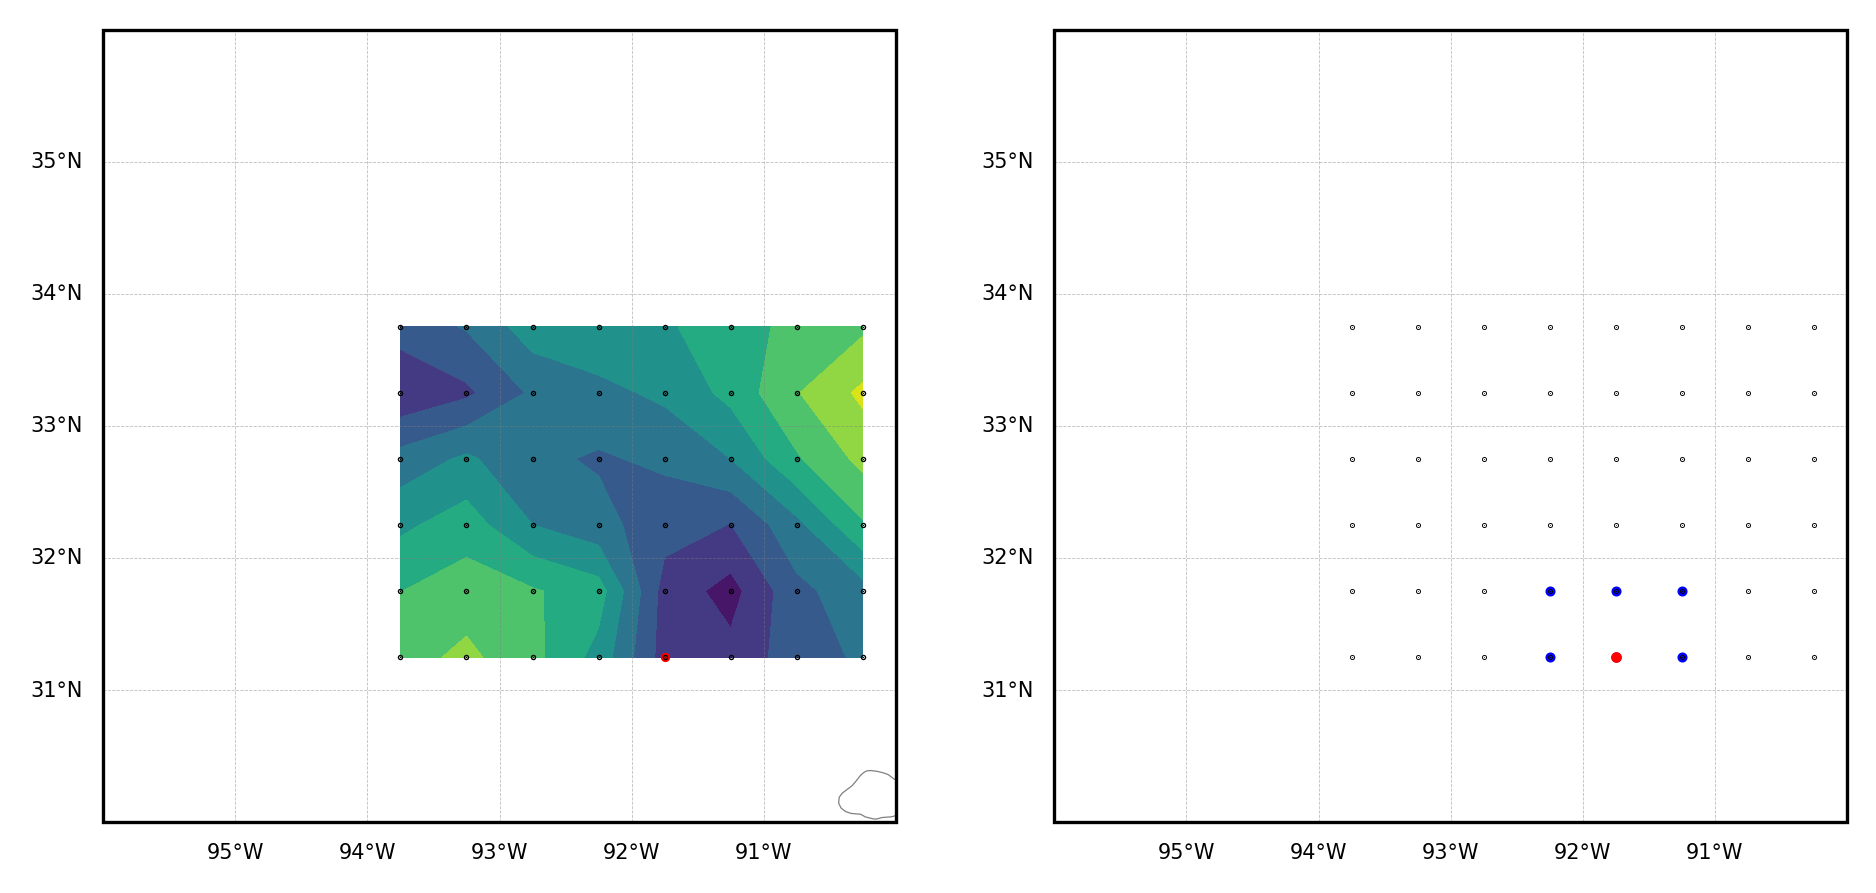

In [8]:
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(7.5,5),dpi=300)
gs = gridspec.GridSpec(1,2)

# =======================================================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
ax1.add_feature(cf.COASTLINE,linewidth=0.3,color='grey')
ax1.add_feature(cf.BORDERS,linewidth=0.3,color='grey')
ax1.set_extent([-96, -90, 30, 36], crs=proj)
ax1.contourf(lon2d, lat2d, np.mean(xrs,axis=2).T)
ax1.scatter(clon, clat, s=1.5, color='r')
ax1.scatter(lon2d, lat2d ,s=0.1, color='k')

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.xlabel_style = {'size': 5, 'color': 'k'}
gl.ylabel_style = {'size': 5, 'color': 'k'}

# =======================================================================================================
ax1 = plt.subplot(gs[0, 1], projection = proj)
ax1.set_extent([-96, -90, 30, 36], crs=proj)
ax1.scatter(clon, clat, s=2.5, color='r', zorder=10)
# ax1.scatter(box_3h['lon'], box_3h['lat'], s=2, color='b')
ax1.scatter(lon2d_box, lat2d_box,s=2, color='b')
ax1.scatter(lon2d, lat2d ,s=0.05, color='k')

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.xlabel_style = {'size': 5, 'color': 'k'}
gl.ylabel_style = {'size': 5, 'color': 'k'}

In [9]:
nvars = 17
DOWN_PAR = np.zeros([nvars, nlat-2, nlon-2]) # Borders or limits are excluded
# DOWN_PAR = []

for la in range(1,nlat-2):
    for lo in range(1,nlon-2):

        clat = tmpalat[la]
        clon = tmpalon[lo]

        x = da.from_array(dset, chunks=(6, 6, 300))
        xrs0 = xr.DataArray(x,  coords={'lon':tmpalon, 'lat':tmpalat, 'time':dates}, dims=('lon', 'lat', 'time'))

        # set negative values to NaN (missing values)
        xrs = xrs0.where(xrs0 >= -0.001)
        nlon = xrs.shape[0]
        nlat = xrs.shape[1]
        ntime = xrs.shape[2]

        solat = clat - buffer + eps
        nolat = clat + buffer + eps
        ealon = clon + buffer + eps
        welon = clon - buffer + eps
        bcond = np.logical_and(
                    np.logical_and( xrs.lat > solat, xrs.lat < nolat),
                    np.logical_and( xrs.lon > welon, xrs.lon < ealon))

        # XARRAY WITH VALUES LOADED IN MEMORY
        box_3h = xrs.where(bcond, drop = True).load()

        downres = down.downscale_WITHOUT_PRINT(box_3h, Tr=50, thresh=1.0, L0=0.0001, toll=0.005,
                            acf='mar', save_yearly=True,
                            maxmiss=300, clat=clat, clon=clon,
                            opt_method='genetic', plot=False) # maxmiss=36 original parameter

        DOWN_PAR[0,la,lo] = downres['eps_s']
        DOWN_PAR[1,la,lo] = downres['alp_s']
        DOWN_PAR[2,la,lo] = downres['mev_s']

        DOWN_PAR[3,la,lo] = downres['eps_d']
        DOWN_PAR[4,la,lo] = downres['alp_d']
        DOWN_PAR[5,la,lo] = downres['mev_d']

        DOWN_PAR[6,la,lo] = downres['gam_d']
        DOWN_PAR[7,la,lo] = downres['gam_s']
        
        DOWN_PAR[8,la,lo] = downres['beta']

        DOWN_PAR[9,la,lo] = downres['Nd']
        DOWN_PAR[10,la,lo] = downres['Cd']
        DOWN_PAR[11,la,lo] = downres['Wd']

        DOWN_PAR[12,la,lo] = downres['Ns']
        DOWN_PAR[13,la,lo] = downres['Cs']
        DOWN_PAR[14,la,lo] = downres['Ws']

        DOWN_PAR[15,la,lo] = downres['clat']
        DOWN_PAR[16,la,lo] = downres['clon']

        print()

differential_evolution step 1: f(x)= 0.012028118545191502
differential_evolution step 2: f(x)= 0.012028118545191502
differential_evolution step 3: f(x)= 0.012028118545191502
differential_evolution step 4: f(x)= 0.012028118545191502
differential_evolution step 5: f(x)= 0.012028118545191502
differential_evolution step 6: f(x)= 0.012028118545191502
differential_evolution step 7: f(x)= 0.012027280720668387
Polishing solution with 'L-BFGS-B'

differential_evolution step 1: f(x)= 0.006216379279090614
differential_evolution step 2: f(x)= 0.00578659638987203
differential_evolution step 3: f(x)= 0.00578659638987203
differential_evolution step 4: f(x)= 0.00578659638987203
differential_evolution step 5: f(x)= 0.00577135126591867
Polishing solution with 'L-BFGS-B'

differential_evolution step 1: f(x)= 0.002871452210244748
differential_evolution step 2: f(x)= 0.002871452210244748
differential_evolution step 3: f(x)= 0.002871452210244748
differential_evolution step 4: f(x)= 0.002871452210244748
diff

In [10]:
lon_min, lon_max, lat_min, lat_max = -93.5, -90.5, 31.5, 33.5

lon2d, lat2d = np.meshgrid(xrs0['lon'][1:-1], xrs0['lat'][1:-1])

Text(0.0, 1.0, '(c) Ns')

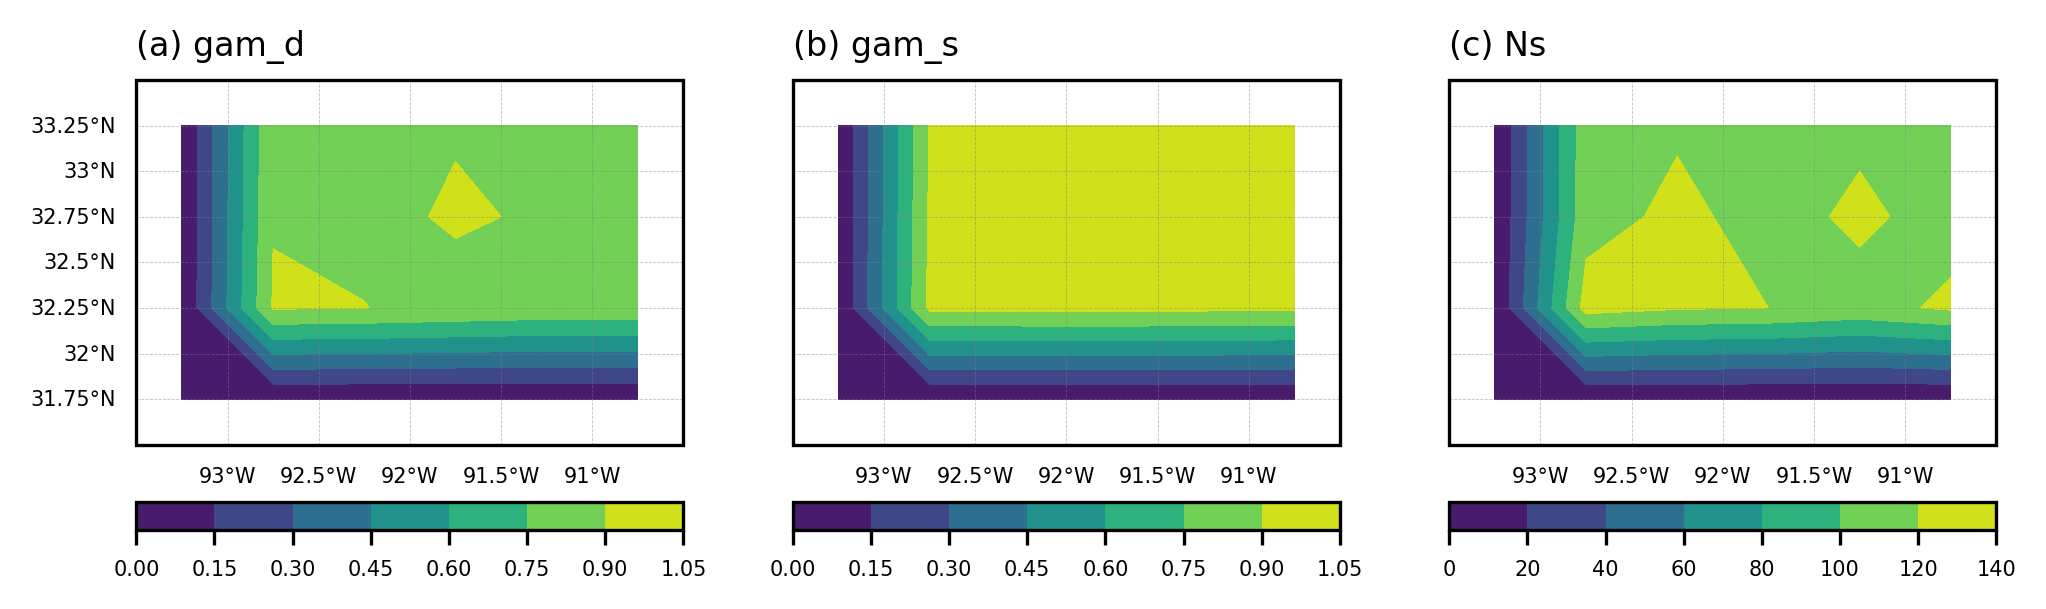

In [46]:
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(8,5),dpi=300)
gs = gridspec.GridSpec(1,3)

# =======================================================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
ax1.add_feature(cf.COASTLINE,linewidth=0.3,color='grey')
ax1.add_feature(cf.BORDERS,linewidth=0.3,color='grey')
ax1.set_extent([lon_min, lon_max, lat_min, lat_max], crs=proj)
a1 = ax1.contourf(lon2d, lat2d, DOWN_PAR[6,:,:])

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = True
gl.xlabel_style = {'size': 5, 'color': 'k'}
gl.ylabel_style = {'size': 5, 'color': 'k'}

cbar = plt.colorbar(a1, fraction=0.04, orientation='horizontal', pad=0.05)
cbar.ax.tick_params(labelsize=5)

ax1.set_title('(a) gam_d', loc='left', fontsize=8)

# =======================================================================================================
ax1 = plt.subplot(gs[0, 1], projection = proj)
ax1.set_extent([lon_min, lon_max, lat_min, lat_max], crs=proj)
a1 = ax1.contourf(lon2d, lat2d, DOWN_PAR[7,:,:])

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = False
gl.xlabel_style = {'size': 5, 'color': 'k'}
gl.ylabel_style = {'size': 5, 'color': 'k'}

cbar = plt.colorbar(a1, fraction=0.04, orientation='horizontal', pad=0.05)
cbar.ax.tick_params(labelsize=5)

ax1.set_title('(b) gam_s', loc='left', fontsize=8)

# =======================================================================================================
ax1 = plt.subplot(gs[0, 2], projection = proj)
ax1.set_extent([lon_min, lon_max, lat_min, lat_max], crs=proj)
a1 = ax1.contourf(lon2d, lat2d, DOWN_PAR[12,:,:])

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = False
gl.xlabel_style = {'size': 5, 'color': 'k'}
gl.ylabel_style = {'size': 5, 'color': 'k'}

cbar = plt.colorbar(a1, fraction=0.04, orientation='horizontal', pad=0.05)
cbar.ax.tick_params(labelsize=5)

ax1.set_title('(c) Ns', loc='left', fontsize=8)

In [41]:
PARAM_xr = xr.Dataset(data_vars=
                        {
                        "eps_s": (("lat","lon"), DOWN_PAR[0,:,:]),
                        "alp_s": (("lat","lon"), DOWN_PAR[1,:,:]),
                        "mev_s": (("lat","lon"), DOWN_PAR[2,:,:]),
                        
                        "eps_d": (("lat","lon"), DOWN_PAR[3,:,:]),
                        "alp_d": (("lat","lon"), DOWN_PAR[4,:,:]),
                        "mev_d": (("lat","lon"), DOWN_PAR[5,:,:]),
                        
                        "gam_d": (("lat","lon"), DOWN_PAR[6,:,:]),
                        "gam_s": (("lat","lon"), DOWN_PAR[7,:,:]),
                        
                        "beta": (("lat","lon"), DOWN_PAR[8,:,:]),
                        
                        "Nd": (("lat","lon"), DOWN_PAR[9,:,:]),
                        "Cd": (("lat","lon"), DOWN_PAR[10,:,:]),
                        "Wd": (("lat","lon"), DOWN_PAR[11,:,:]),
                        
                        "Ns": (("lat","lon"), DOWN_PAR[12,:,:]),
                        "Cs": (("lat","lon"), DOWN_PAR[13,:,:]),
                        "Ws": (("lat","lon"), DOWN_PAR[14,:,:]),
                        },
                    
                    coords={'lat': xrs0['lat'][1:-1], 'lon': xrs0['lon'][1:-1]},
                    attrs=dict(description="MRI ESM2 precipitation for Atlantic Ocean"))

PARAM_xr.lat.attrs["units"] = "degrees_north"
PARAM_xr.lon.attrs["units"] = "degrees_east"

In [42]:
print(f'Export PRE data to {os.path.join(output_file,'down_parameters_test.nc')}')
PARAM_xr.to_netcdf(os.path.join(output_file,'down_parameters_test.nc'))

Export PRE data to ../data/down_test/down_parameters_test.nc
